In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [15]:
def calStability(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                continue
                
            
            _ideal = offline[offline["task_index"]==1]["accuracy"]
            val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
            values[m].append(val)
    
    return values

In [30]:
def calPlasticity(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                continue
    
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            if len(_m) != len(_ideal):
                values[m].append(np.nan)
                continue
            
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            # Ignore when val is much more than 4; due to deternimator is too large
            if val > 4:
                _m = list(_m["accuracy"])
                _ideal = list(_ideal)
                
                cnt = 0
                acc = 0.0
                for i in range(len(_m)):
                    if _m[i] / _ideal[i] > 4:
                        print("\t SKIP", "m=", _m[i] / _ideal[i], "v=", _ideal[i])
                        continue
                        
                    cnt +=1
                    acc += _m[i] / _ideal[i]
                val = acc
                
            
            
            values[m].append(val)
            
    
    return values

In [31]:
def calOverallAcc(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            
            _m = target[target["train_session"]==len(task_index)][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            
            
            if len(_m) != len(_ideal):
#                 print("SKIP", m, t)
                values[m].append(np.nan)
                continue
        
            val = np.nansum(_m["accuracy"].div(_ideal.values, axis=0))/len(_m)
            # Ignore when val is much more than 4; due to deternimator is too large
            if val > 4:
                _m = list(_m["accuracy"])
                _ideal = list(_ideal)
                
                cnt = 0
                acc = 0.0
                for i in range(len(_m)):
                    if _m[i] / _ideal[i] > 4:
                        print("\t SKIP", "m=", _m[i] / _ideal[i], "v=", _ideal[i])
                        continue
                        
                    cnt +=1
                    acc += _m[i] / _ideal[i]
                val = acc
            
            
            
            values[m].append(val)
            
    return values

In [32]:
all_values = {}
for d in ["HouseA", "CASAS", "PAMAP", "DSADS"]:
# for d in ["CASAS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_component_sensitivity/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    raw["train_session"] = pd.to_numeric(raw["train_session"], errors='coerce')
    
    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
        print(c)
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method)
        plasticity.append(m)
        
        m = calOverallAcc(target, task_order, method)
        overallAcc.append(m)
        
    all_values[d] = (stability, plasticity, overallAcc)
    print(d, "DONE")

0
1
2
3
4
5
6
HouseA DONE
0
1
2
3
4
5
6
CASAS DONE
0
1
2
3
4
5
6
PAMAP DONE
0
	 SKIP m= 112.99999999999999 v= 0.006666666666666667
1
	 SKIP m= 112.99999999999999 v= 0.006666666666666667
2
	 SKIP m= 93.0 v= 0.006666666666666667
3
	 SKIP m= 122.0 v= 0.006666666666666667
	 SKIP m= 37.99999999999999 v= 0.006666666666666667
4
5
	 SKIP m= 94.0 v= 0.006666666666666667
6
DSADS DONE


# Plots

In [33]:
from scipy import stats

def plot(values, title, width=0.85, offset_ratio=0, xticks=[], models=None, rotation=-45, filename="plot.pdf"):
    
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.rcParams.update({'font.size': 25})
    plt.rcParams['axes.titlepad'] = 10
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    # values[cmd]["sg-cgan"][task_order]
    for model in models:
        
        tmp = []
        tmperr = []
#         for i, v in enumerate(values):
        for i in [0, 1, 2, 3, 4, 6]:
            v = values[i]
            avg = np.nanmean(v[model])
            err = stats.sem(v[model], nan_policy="omit")
            tmp.append(avg)
            tmperr.append(err)
            
        
        m.append(tmp)
        merr.append(tmperr)
    
    # m[model_index][cmd]
    print("Plot values")
    print(m[0])
    print(merr[0])
    
    ind = np.arange(len(xticks)) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "/" , "\\" , "x" , "-" , "+" , "|", "o", "O", ".", "*" ]
    for i, model in enumerate(models):
        offset = (float(i)/len(models))*width
        offset -= (offset_ratio)*width
        ax.bar(ind + offset, m[i], width*(1.0/len(models)), yerr=merr[i], label=model, hatch=patterns[i])
        
        X = np.arange(-0.5, len(m[0])+0.5)
        Y = [m[i][0] for _ in range(len(X))]
        ax.plot(X, Y, linestyle=':')

    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(xticks, rotation=rotation, rotation_mode="default", fontdict={"fontsize":20}, horizontalalignment='left')
#     ax.legend()

    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()
    

In [34]:
xticks = [
    "None",
    "Self-verify",
    "SMOTE",
    "EWC",
    "LwF",
#     "Instance Noise",
    "All"
]

In [35]:
print("A")

A


Plot values
[0.9039220261416535, 0.9132225030891894, 1.0104312443381782, 0.9585358371342412, 0.9712626426202011, 0.9576774140339784]
[0.054266170321848696, 0.045085395261991276, 0.01858559182841762, 0.03327777869594402, 0.03402070041829345, 0.023100373362101884]


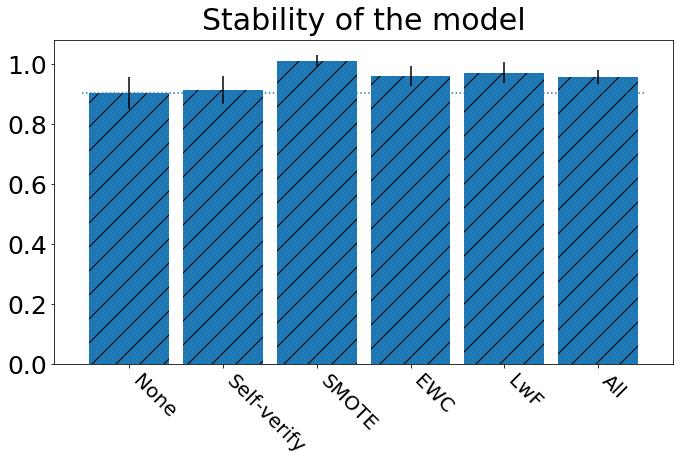

Plot values
[1.1233467412535842, 1.1172861351929781, 1.1109375028435964, 1.1109022140583076, 1.0607630857084682, 1.0273555379075]
[0.020812894615621285, 0.019441043655844075, 0.02001347506697445, 0.021533844371913222, 0.0190535282514743, 0.02235368775224337]


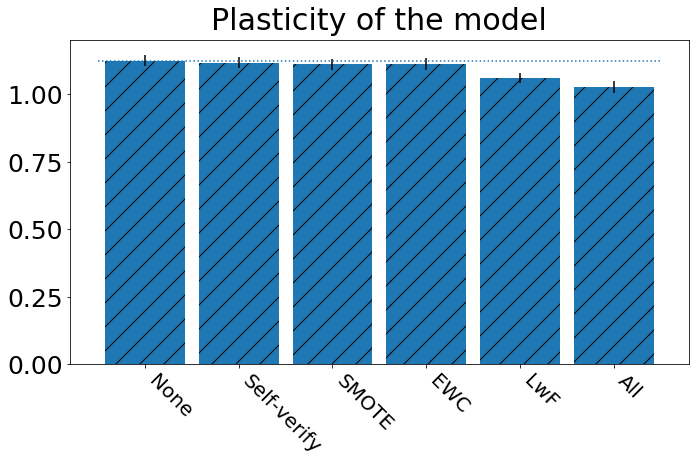

Plot values
[0.8410251911197371, 0.8533559710975759, 0.879512962252815, 0.8740820178795324, 0.8671510211299734, 0.8873550862031699]
[0.04910553350287603, 0.03696957027662049, 0.0328369779262583, 0.027519900640222944, 0.041618701057891005, 0.022489644159626666]


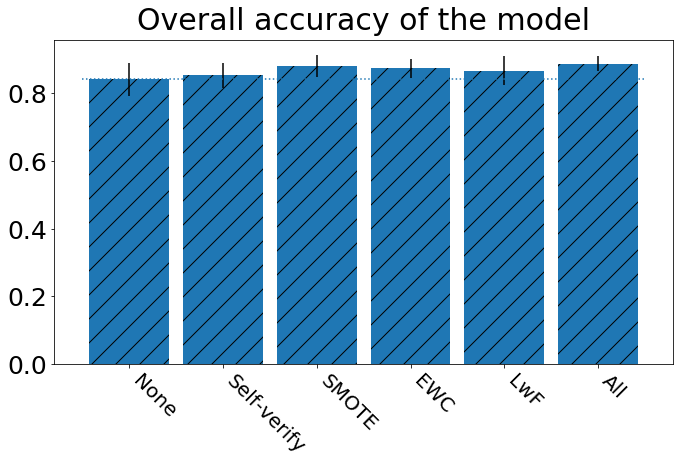

In [36]:
stability, plasticity, overallAcc = all_values["HouseA"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models, filename="comp_HouseA_sta.pdf")
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models, filename="comp_HouseA_pla.pdf")
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models, filename="comp_HouseA_ova.pdf")

Plot values
[1.735213258723451, 1.8737889197200448, 1.66425172377808, 1.574025050015907, 2.379295475429976, 2.5107612670459405]
[0.6897566928786648, 0.7681121311045196, 0.7071147330723638, 0.6142250042413779, 1.0513208230523323, 1.0941494831206864]


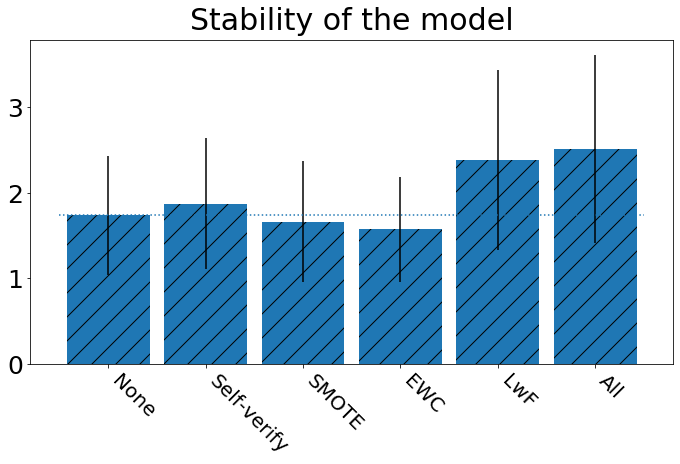

Plot values
[1.6824098562848495, 1.6825873373214661, 1.6626541277849871, 1.6856610337108897, 1.5236111469911642, 1.7908906215620932]
[0.3388320976480698, 0.3391184838086697, 0.3384367678913473, 0.3387633298194256, 0.35556672021987373, 0.45438268771394713]


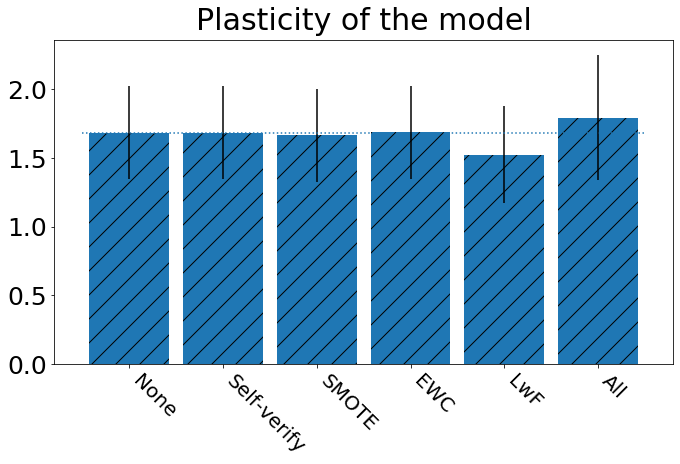

Plot values
[0.7429773490748088, 0.8149651977986168, 0.8300578904328179, 0.8066070227083582, 0.9397373953857964, 1.0771766793939759]
[0.07506516924816937, 0.11854160445113934, 0.10237281100059652, 0.10905367507535993, 0.13413715152782624, 0.12064885700991125]


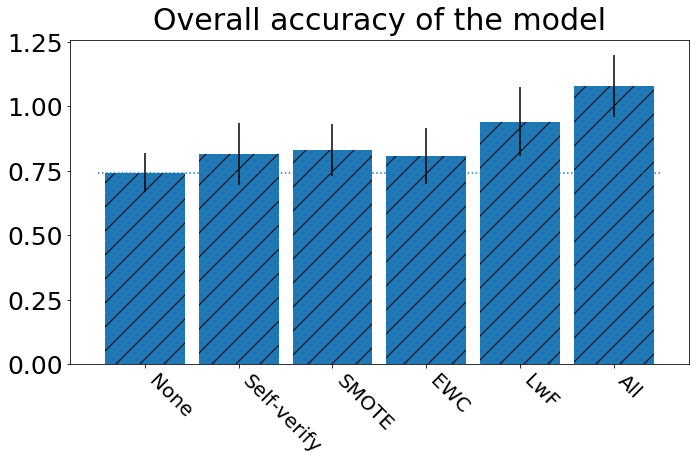

In [37]:

stability, plasticity, overallAcc = all_values["CASAS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models, filename="comp_CASAS_sta.pdf")
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models, filename="comp_CASAS_pla.pdf")
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models, filename="comp_CASAS_ova.pdf")

Plot values
[0.5741449847581164, 0.5950624814209051, 0.7286570338953086, 0.6111200471292214, 0.7853147223455814, 0.7902814951730451]
[0.12314372591218842, 0.13470067918443746, 0.10960323804097777, 0.15383967063799103, 0.181573745977971, 0.034326379415542216]


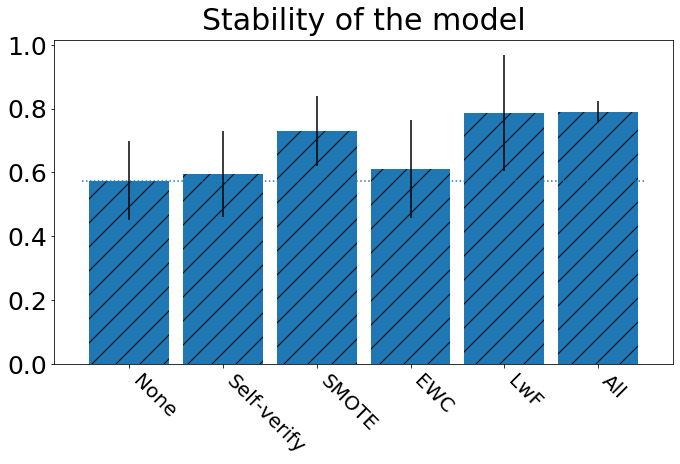

Plot values
[1.237987339039923, 1.1519868137652767, 1.1667331810903863, 1.1528809520816703, 1.0822900990550754, 1.10338022678264]
[0.0606677594833551, 0.03861646746347843, 0.05014939597929804, 0.04006781681101652, 0.03308233744412989, 0.03789990295762008]


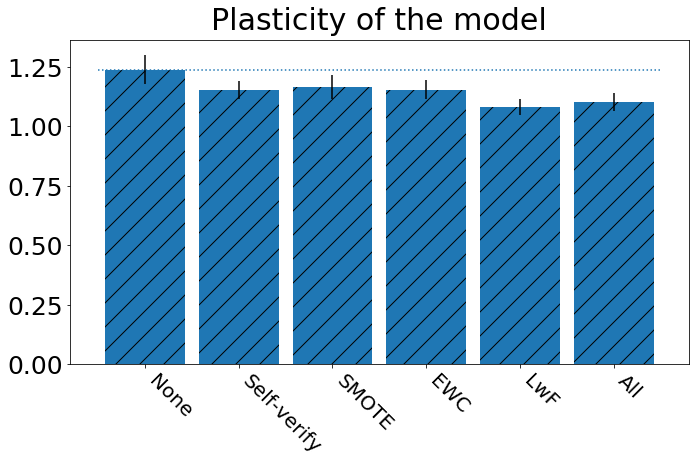

Plot values
[0.6989344144090808, 0.6441106378327659, 0.6563198608564608, 0.5564108944175866, 0.7627971256920482, 0.8006488435389116]
[0.12990523669106704, 0.06734962788003526, 0.08510710908456398, 0.05498448183318644, 0.08216588983973766, 0.04762028242431115]


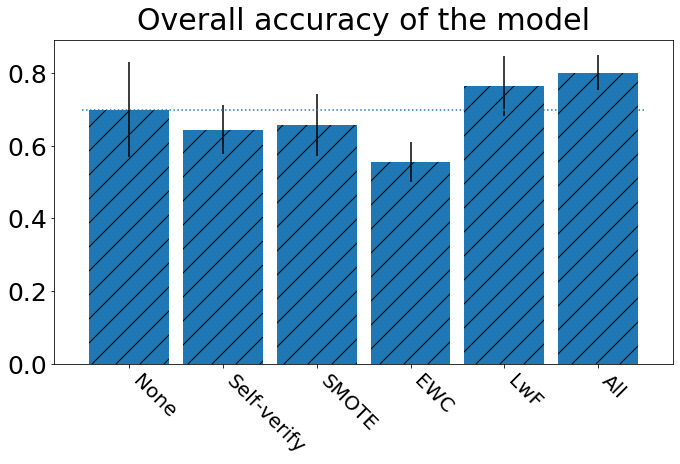

In [38]:

stability, plasticity, overallAcc = all_values["PAMAP"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models, filename="comp_PAMAP_sta.pdf")
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models, filename="comp_PAMAP_pla.pdf")
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models, filename="comp_PAMAP_ova.pdf")

Plot values
[0.6149754442567252, 0.5948266190270332, 0.5671367574499009, 0.6814597924950154, 1.0546662794849875, 1.1409505470790082]
[0.1200311575130339, 0.08977304193877231, 0.09711009194527519, 0.09668254176482403, 0.18698578787774991, 0.2203157459884759]


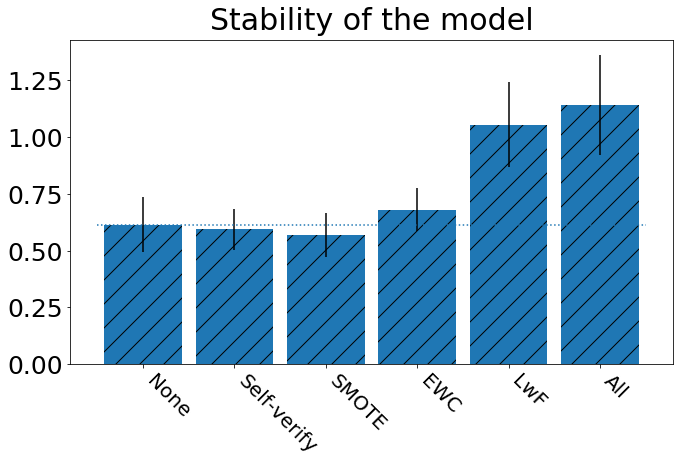

Plot values
[1.9473618460629745, 1.956582953311215, 1.9522533501510095, 1.938063872520886, 1.1647018471444321, 1.3285327744868296]
[0.4267319372701224, 0.42494229288648244, 0.42593012681764475, 0.4267446372939683, 0.12703396610276846, 0.12384842746490944]


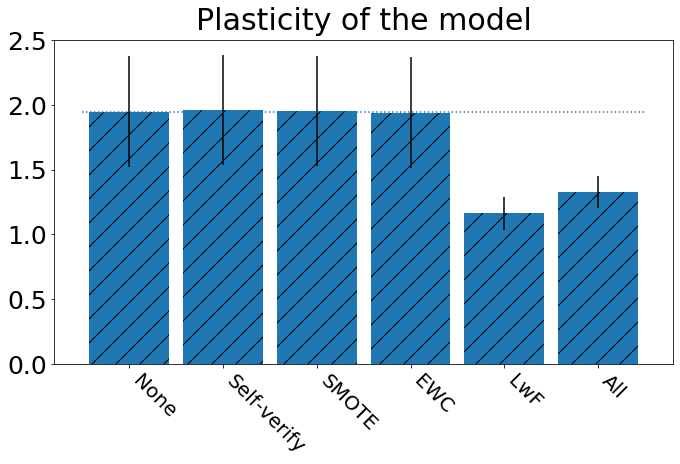

Plot values
[0.74382890845924, 0.536210038730047, 0.42214757536397585, 0.6145299278773247, 0.5492195136011464, 0.745436688793801]
[0.32081004382302236, 0.05760534787116699, 0.06459862899507583, 0.22226888661010846, 0.0716616548027131, 0.03353720232784853]


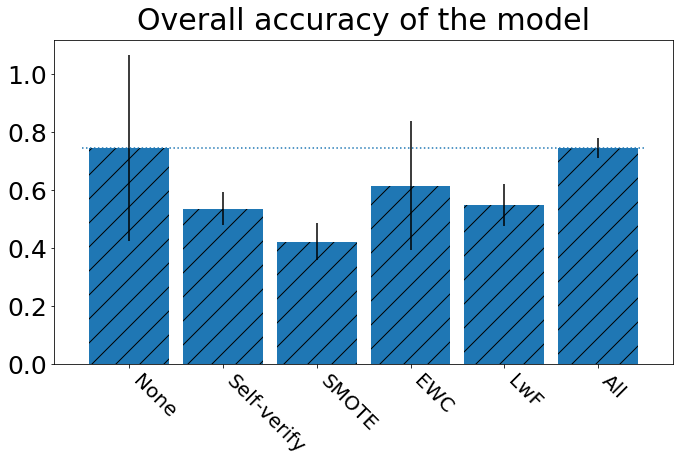

In [39]:

stability, plasticity, overallAcc = all_values["DSADS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models, filename="comp_DSADS_sta.pdf")
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models, filename="comp_DSADS_pla.pdf")
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models, filename="comp_DSADS_ova.pdf")